In [16]:
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input, decode_predictions
import keras.preprocessing.image as kerasImage
import keras.backend as K
import numpy as np
import math
import os
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
# -- DEFINE FUNCTIONS -- #
def load_image(path,targetSize=(224,224),preprocess=True):
    data = kerasImage.load_img(path,target_size=targetSize)
    if preprocess:
        data = kerasImage.img_to_array(data)
        data = np.expand_dims(data,axis=0)
        data = preprocess_input(data)
    return data

def deprocess_image(x):
    x -= x.mean(); x /= (x.std() + K.epsilon()); x *= 0.1
    # CLIP DATA
    x += 0.5; x = np.clip(x, 0, 1)
    # CONVERT TO RGB
    x *= 255; x = np.clip(x, 0, 255).astype('uint8')
    return x

In [11]:
# -- CHOOSE PARAMETERS -- #
selImg = input('Select an image to test: ')
fileName = './Data/images/'+selImg+'.jpg'
occSize = int(input('Select the size of the occlusion mask: (1-56)'))
occStride = int(input('Select the stride of the occlusion mask (1-10)'))

Select an image to test:  test_76
Select the size of the occlusion mask: (1-56) 20
Select the stride of the occlusion mask (1-10) 5


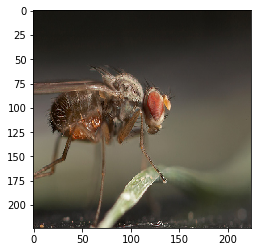

In [12]:
# -- LOAD MODEL -- #
model = VGG16(weights='imagenet',include_top=True)

# -- LOAD IMAGE -- #
imgInput = load_image(fileName)
H,W,_ = imgInput[0].shape
outH = int(math.ceil((H-occSize)/(occStride+1)))
outW = int(math.ceil((W-occSize)/(occStride+1)))
heatMap = np.zeros((outH,outW))
plt.imshow(load_image(fileName,preprocess=False))
plt.show()

In [13]:
# -- INITIAL PREDICTION -- #
fullPred = model.predict(imgInput)
maxClass = decode_predictions(fullPred)[0][0][1]
print(maxClass)
# -- HEATMAP -- #
k = 1
print('------------------')
for row in range(outH):
    for col in range(outW):
        startH = row*occStride; endH = min(H,startH+occSize)
        startW = col*occStride; endW = min(W,startW+occSize)
        imgData = imgInput.copy()
        imgData[:,startH:endH,startW:endW,:] = 0
        prediction = model.predict(imgData)
        decoded = decode_predictions(prediction)[0]
        result = [item for item in decoded if maxClass in item]
        if not result:
            heatMap[row,col] = 0.0
        else:
            heatMap[row,col] = result[0][2]
        if k % 50 == 0:
            print('Result: '+result[1]+' ['+str(result[2])+']')
            print(str(k)+' out of '+str(outH*outW))
            print('------------------')
        k += 1

# -- INVERT HEATMAP -- #
invHeatMap = 1-heatMap

fly
------------------
Result: [('n02190166', 'fly', 0.9349147)]
50 out of 1156
------------------
Result: [('n02190166', 'fly', 0.9502052)]
100 out of 1156
------------------
Result: [('n02190166', 'fly', 0.90520597)]
150 out of 1156
------------------
Result: [('n02190166', 'fly', 0.9440425)]
200 out of 1156
------------------
Result: [('n02190166', 'fly', 0.83624744)]
250 out of 1156
------------------
Result: [('n02190166', 'fly', 0.9240394)]
300 out of 1156
------------------
Result: [('n02190166', 'fly', 0.9040438)]
350 out of 1156
------------------
Result: [('n02190166', 'fly', 0.8887559)]
400 out of 1156
------------------
Result: [('n02190166', 'fly', 0.9440558)]
450 out of 1156
------------------
Result: [('n02190166', 'fly', 0.8642914)]
500 out of 1156
------------------
Result: [('n02190166', 'fly', 0.9699845)]
550 out of 1156
------------------
Result: [('n02190166', 'fly', 0.80826646)]
600 out of 1156
------------------
Result: [('n02190166', 'fly', 0.95291024)]
650 out 

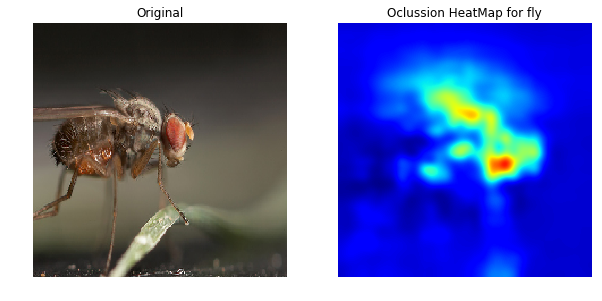

In [37]:
# -- REPRESENT RESULT -- #
if not os.path.isdir('./Results/Occlusion'):
    os.mkdir('./Results/Occlusion')
savePath = './Results/Occlusion/'+selImg+'.png'
fig = plt.figure(figsize=(10, 8))
plt.subplot(121)
plt.title('Original')
plt.axis('off')
plt.imshow(load_image(fileName,preprocess=False))
plt.subplot(122)
plt.title('Oclussion HeatMap for '+maxClass)
plt.axis('off')
plt.imshow(invHeatMap,cmap='jet',interpolation='bilinear')
fig.savefig(savePath,dpi=250)